In [2]:
import torch
import math
import gym

In [3]:
size = 200
x1 = torch.linspace(0, 200, size)/10.+ (torch.rand(size)*4.-2.)
x2 = torch.linspace(0, 200, size)/20.+ (torch.rand(size)*6.-3.)
x3 = torch.linspace(0, 200, size)/30.+ (torch.rand(size)*8.-4.)
x = torch.transpose(torch.vstack((x1,x2,x3)),1,0)
y = 1./3.*(x1+2.*x2+torch.sin(x3))-5.

In [4]:
prob = 0.8 #randomly permutate the 1:200 indices and select the first 80% as training set
random_idx = torch.randperm(size)
idx_train = random_idx[:math.floor(size*prob)]
idx_test = random_idx[math.floor(size*prob):]
x_train = x[idx_train,]
y_train = y[idx_train]#print(xtrain.size())
x_test = x[idx_test,]#print(xtest.size())
y_test = y[idx_test]

In [5]:
class Scaler:
    def __init__(self, x, y):
        self.x_mean = torch.mean(x, axis=0)
        self.y_mean= torch.mean(y)
        self.x_std = torch.std(x, axis=0)
        self.y_std = torch.std(y)
        
    def getx(self):
        return self.x_std, self.x_mean # return saved mean and std dev of x

    def gety(self):
        return self.y_std, self.y_mean # return saved mean and std dev of y

In [7]:
# normalize the training data
normalizer = Scaler(x_train, y_train)
x_std, x_mean = normalizer.getx()
y_std, y_mean = normalizer.gety()
x_train_norm = (x_train-x_mean)/ x_std
x_test_norm = (x_test-x_mean)/ x_std
y_train_norm = (y_train-y_mean)/ y_std

In [8]:
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(Feedforward, self).__init__() # Inherited from the parent class nn.Module
        self.fc1 = torch.nn.Linear(input_size, hidden_size1)
        self.fc2 = torch.nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = torch.nn.Linear(hidden_size2, 1)
        self.relu = torch.nn.ReLU() # Non−Linear ReLU Layer: max(0,x)
        
    def forward(self, x): # Forward pass: stacking each layer together
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        
        return out

In [9]:
model = Feedforward(3, 5, 5)
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [12]:
model.parameters()

<generator object Module.parameters at 0x7fcbbd81f6d0>

In [10]:
x_train.size()

torch.Size([160, 3])

In [36]:
# Sets the module in training mode.
model.train()
epoch = 100
batch_size = 32

# for each training epoch
for epoch in range(epoch):
    
    #shuffle the training dataset (it's the same training dataset, just shuffled)
    random_idx = torch.randperm(x_train.size()[0])
    x_train_norm_shuff = x_train_norm[random_idx,]
    y_train_norm_shuff = y_train_norm[random_idx]
    
    # forward and backward passes in batches
    for batch in range(math.ceil(x_train.size()[0] / batch_size)):
        # get the current batch of training data (x and y)
        x_train_norm_batch = x_train_norm_shuff[(batch*batch_size):((batch+1)*batch_size),]
        y_train_norm_batch = y_train_norm_shuff[(batch*batch_size):((batch+1)*batch_size)]
        
        # reset optimizer gradients to zero
        optimizer.zero_grad()
        
        # do forward pass to produce predicted y
        y_train_pred_norm = model(x_train_norm_batch)
        
        # compute loss between predicted y and true y
        loss = mse(y_train_pred_norm.squeeze(), y_train_norm_batch)
        
        # do backward pass to compute the gradients of the loss wrt NN parameters
        loss.backward()
        
        # optimizer updates the parameter according to gradients 
        optimizer.step()

In [37]:
# Sets the module in evaluation mode.
model.eval()
y_test_pred_norm = model(x_test_norm)
y_test_pred = y_test_pred_norm*y_std+y_mean

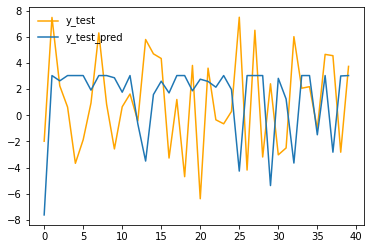

In [40]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)
ax.plot(y_test, color="orange", label="y_test")
ax.plot(y_test_pred.squeeze().detach().numpy(), label="y_test_pred")
plt.legend(loc="upper left", frameon=False)
plt.show()